In [1]:
%pip install nbconvert

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: nbconvert in c:\users\lenovo\desktop\sentiment analysis\.venv\lib\site-packages (7.16.4)




[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install ipywidgets



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: c:\Users\LENOVO\Desktop\Sentiment analysis\.venv\Scripts\python.exe -m pip install --upgrade pip



  Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()

(568454, 10)
(500, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## EDA

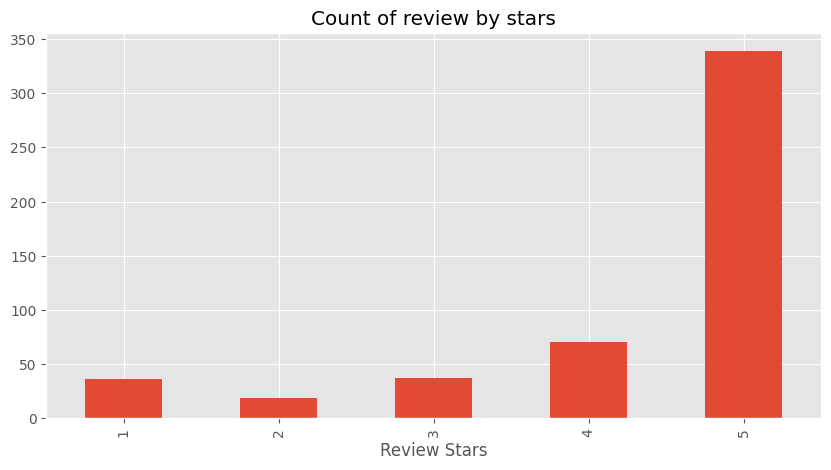

In [4]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of review by stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [5]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

## Pos tagging abreviations meaning and examples
![](Pos_tagging.png)

In [8]:
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1: VADER Sentiment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.
* This uses a "bag of words" approach:
  * Stop words are removed
  * Each word is scored and combined to a total score

In [9]:
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

* **'neg' (Negative):** 
  * The score represents the proportion of negative sentiment in the text. 
  * It ranges from 0 (no negativity) to 1 (completely negative).

* **'neu' (Neutral):**
  * The score represents the proportion of neutral sentiment in the text. 
  * It ranges from 0 (no neutrality) to 1 (completely neutral).

* **'pos' (Positive):** 
  * The score represents the proportion of positive sentiment in the text.
  * It ranges from 0 (no positivity) to 1 (completely positive).

* **'compound':** 
  * The overall sentiment score that combines the other three. 
  * It ranges from -1 (most negative) to 1 (most positive), where:
    * -1 to -0.05 indicates negative sentiment.
    * -0.05 to 0.05 indicates neutral sentiment.
    * 0.05 to 1 indicates positive sentiment.

In [11]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 850.35it/s]


In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
#Now we have sentiment score and meta data
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

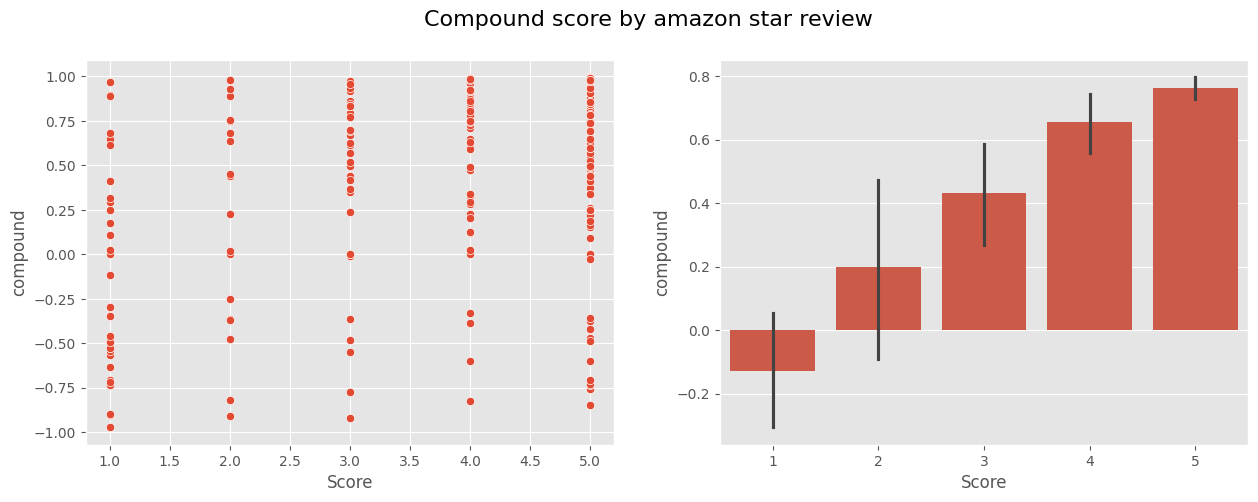

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=vaders, x='Score', y='compound', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='compound', ax=axs[1])

fig.suptitle("Compound score by amazon star review", fontsize=16)
plt.show()

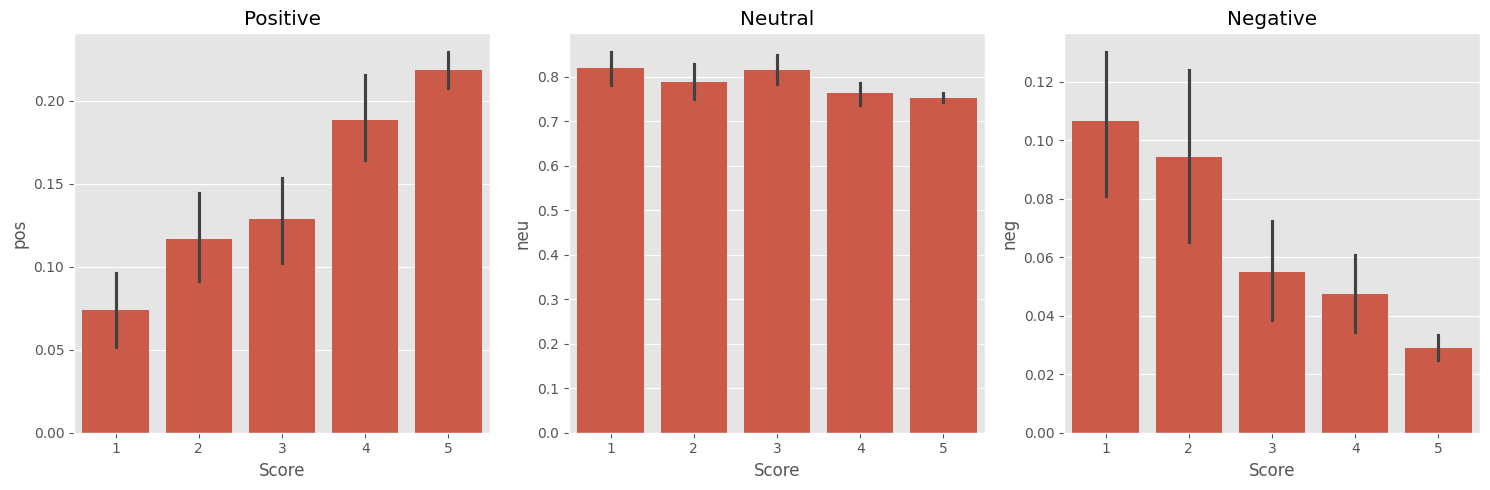

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title ('Positive')
axs[1].set_title ('Neutral')
axs[2].set_title ('Negative')
plt.tight_layout()
plt.show()

## Step 3: Roberta Pretrained Model
  * Use a model trained of a large corpus of data
  * Transformer model accounts for the words but also the context related to other words

In [18]:
# %pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
# %pip install torch
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
#VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [21]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

scores_dict

{'roberta_neg': np.float32(0.97635514),
 'roberta_neu': np.float32(0.020687466),
 'roberta_pos': np.float32(0.0029573706)}

In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        
        roberta_result = polarity_scores_roberta(text)
        
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except:
        print(f"Broke at {myid}")

res

 17%|█▋        | 83/500 [00:41<02:03,  3.39it/s]

Broke at 83


 37%|███▋      | 186/500 [01:28<01:59,  2.64it/s]

Broke at 187


100%|██████████| 500/500 [04:14<00:00,  1.97it/s]


{1: {'vader_neg': 0.0,
  'vader_neu': 0.695,
  'vader_pos': 0.305,
  'vader_compound': 0.9441,
  'roberta_neg': np.float32(0.009624231),
  'roberta_neu': np.float32(0.049980387),
  'roberta_pos': np.float32(0.94039536)},
 2: {'vader_neg': 0.138,
  'vader_neu': 0.862,
  'vader_pos': 0.0,
  'vader_compound': -0.5664,
  'roberta_neg': np.float32(0.5089861),
  'roberta_neu': np.float32(0.45241353),
  'roberta_pos': np.float32(0.038600333)},
 3: {'vader_neg': 0.091,
  'vader_neu': 0.754,
  'vader_pos': 0.155,
  'vader_compound': 0.8265,
  'roberta_neg': np.float32(0.003228897),
  'roberta_neu': np.float32(0.09806738),
  'roberta_pos': np.float32(0.8987037)},
 4: {'vader_neg': 0.0,
  'vader_neu': 1.0,
  'vader_pos': 0.0,
  'vader_compound': 0.0,
  'roberta_neg': np.float32(0.0022951285),
  'roberta_neu': np.float32(0.090219185),
  'roberta_pos': np.float32(0.90748566)},
 5: {'vader_neg': 0.0,
  'vader_neu': 0.552,
  'vader_pos': 0.448,
  'vader_compound': 0.9468,
  'roberta_neg': np.float32(

In [31]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index' : 'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare Scores between models (VADER vs ROBERTA)

In [32]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

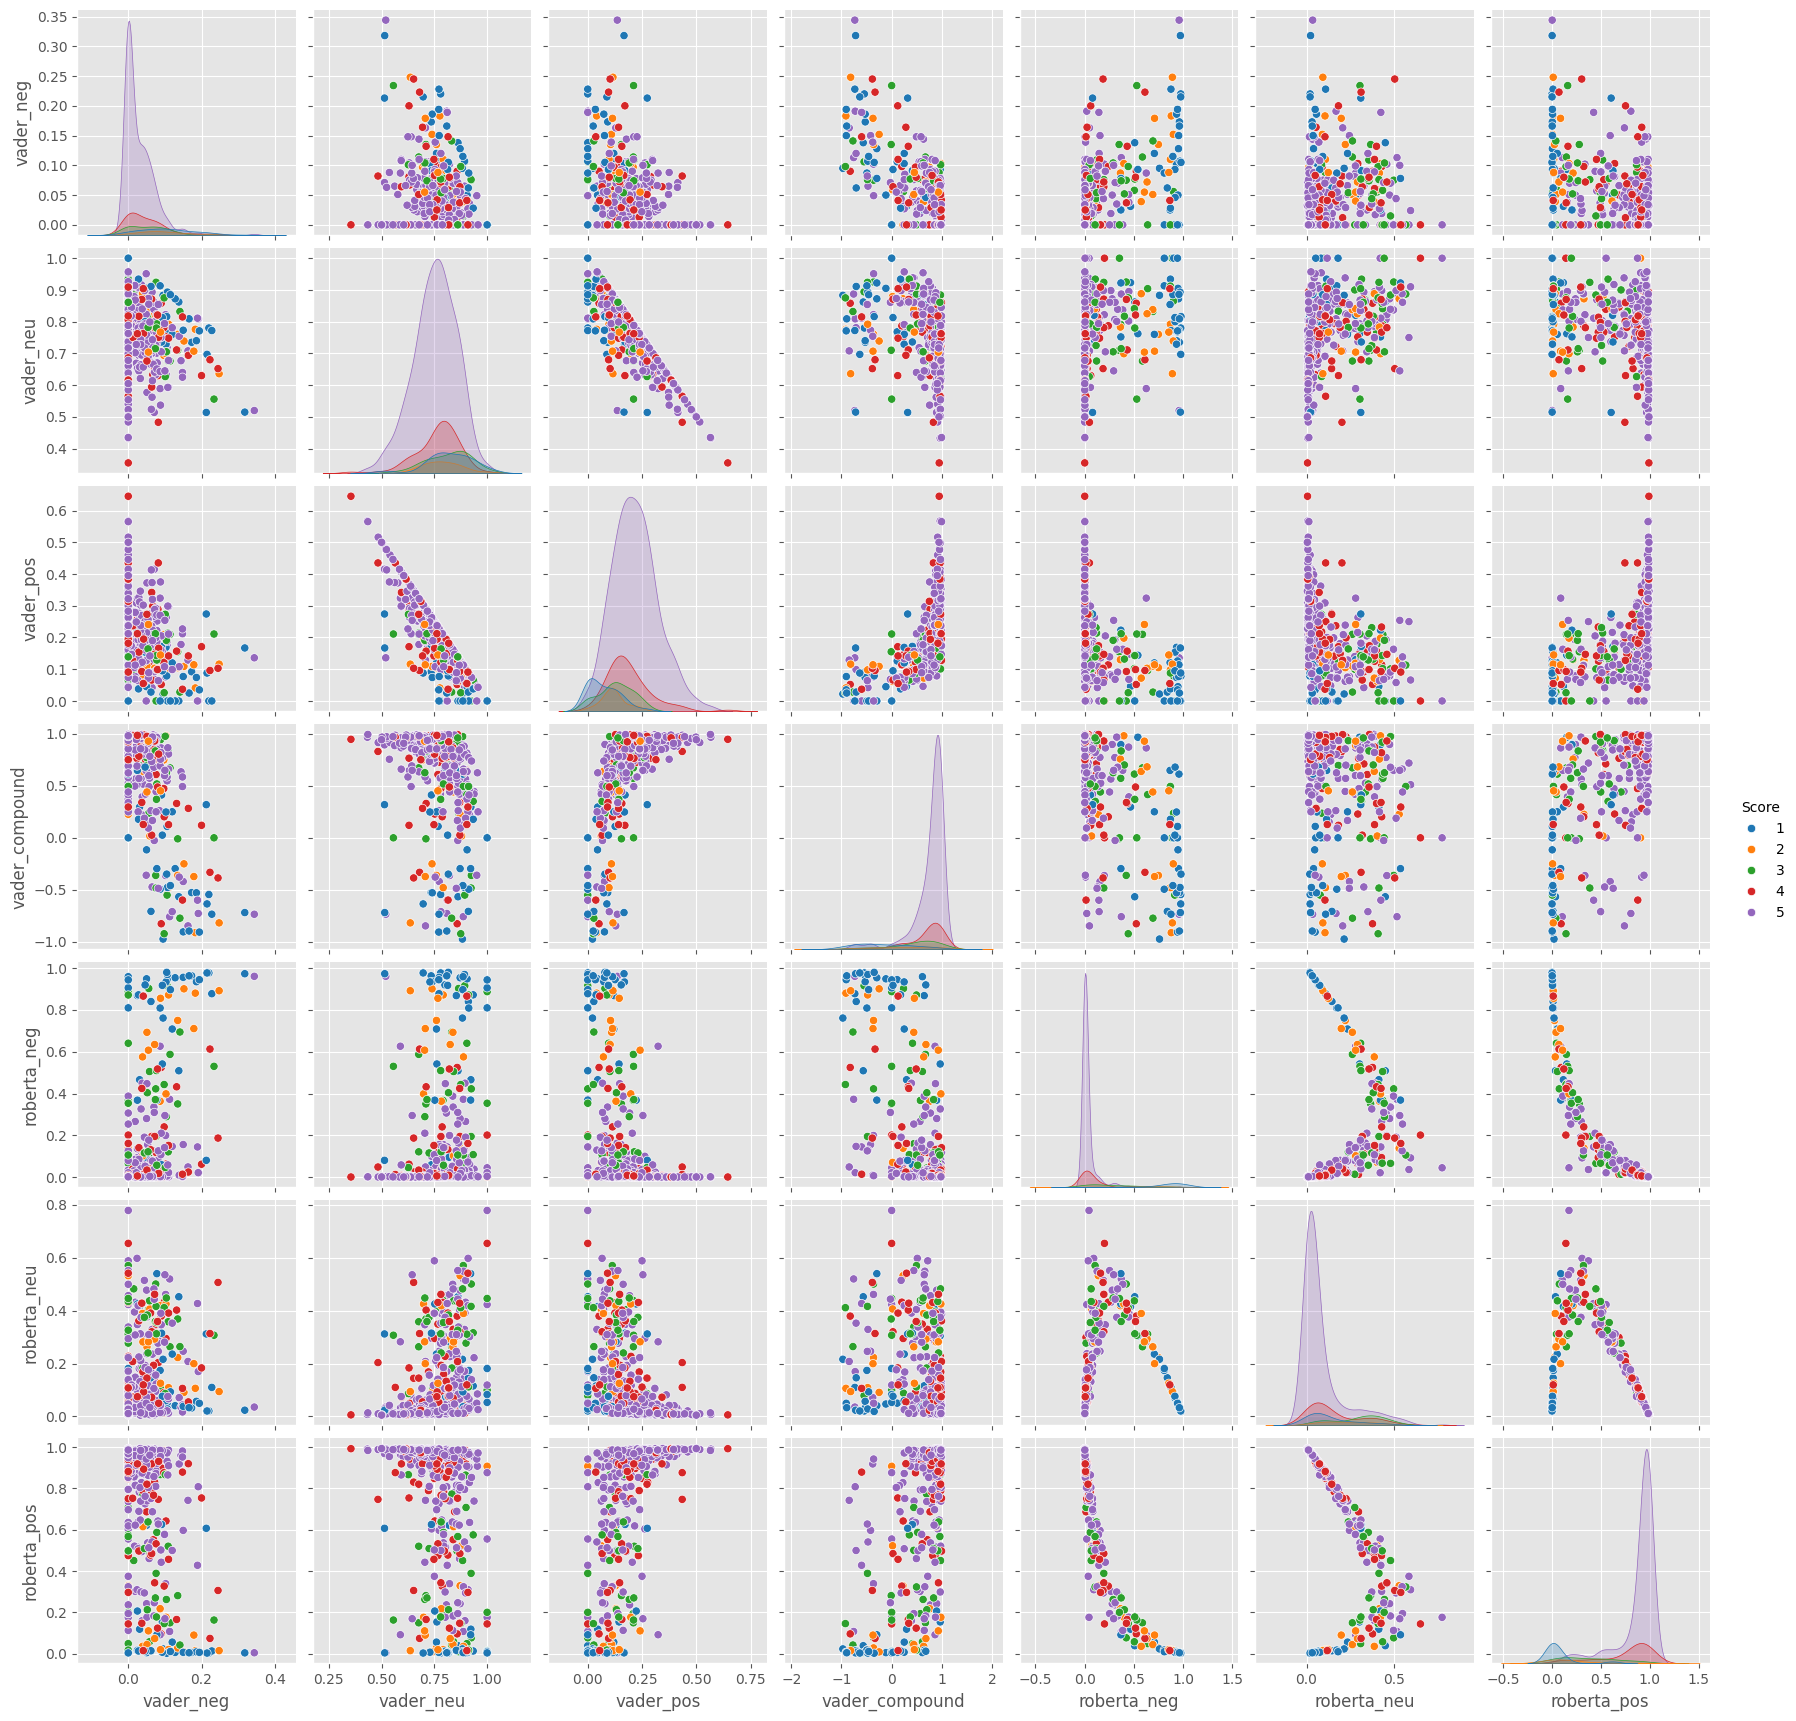

In [35]:
sns.pairplot(data=results_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Step 4 : Review examples :
  * Positive 1-Star and Negative 5-Star reviews
  * Let's look at some examples where the model scoring and review score differ the most.

In [64]:
print("Review that has score 1 and the highest positive vader value :")
results_df.query('Score == 1').sort_values(by='vader_pos', ascending=False)['Text'].values[0]

Review that has score 1 and the highest positive vader value :


'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [65]:
print("Review that has score 1 and the highest positive roberta value :")
results_df.query('Score == 1').sort_values(by='roberta_pos', ascending=False)['Text'].values[0]

Review that has score 1 and the highest positive roberta value :


'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [ ]:
# Negative sentiment 5-star review

In [ ]:
print("Review that has score 5 and the highest negative vader value :")
results_df.query('Score == 5').sort_values(by='vader_neg', ascending=False)['Text'].values[0]

Review that has score 1 and the highest positive vader value :


'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [68]:
print("Review that has score 5 and the highest negative roberta value :")
results_df.query('Score == 5').sort_values(by='roberta_neg', ascending=False)['Text'].values[0]

Review that has score 5 and the highest negative roberta value :


'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

EXTRA : The transformers pipeline
 * Quick and easy way to run sentiment predictions

In [69]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

c:\Users\LENOVO\Desktop\Sentiment analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [70]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [73]:
sent_pipeline('i want it')

[{'label': 'POSITIVE', 'score': 0.9996682405471802}]